# Imports COCO dataset

In [72]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io
import math
import random

# Imports MediaPipe

In [73]:
import scipy.io
import os
import mediapipe as mp
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import shutil

# Imports for boths

In [74]:
import numpy as np

# Imports YOLO

In [75]:
from ultralytics import YOLO
#from ultralytics.utils.plotting import Annotator

# Load test images for model MediaPipe

In [76]:
N = 10
MEDIAPIPE_IMAGES_DIR = "./MEDIAPIPE_images"
output_folder= "./raw_images"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load annotations from COCO dataset

In [77]:
dataDir = './coco/'
dataType = 'val2017'
annFile_kps = '{}/annotations/person_keypoints_{}.json'.format(dataDir, dataType)
coco_kps = COCO(annFile_kps)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


# Get'person' category ID and get image ID with 'person' category and list to store true keypoints coordenates

In [78]:
catIds = coco_kps.getCatIds(catNms=['person'])
imgIds = coco_kps.getImgIds(catIds=catIds)[:10]

# Load and show the first 10 images with Keypoints and get keypoints coordenates

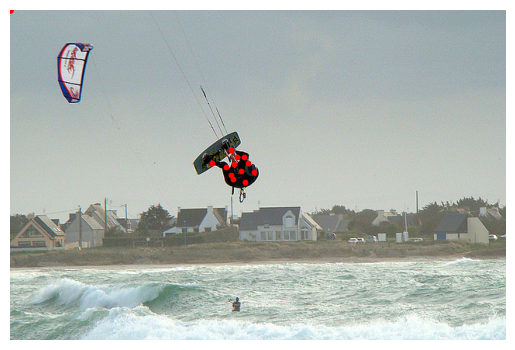

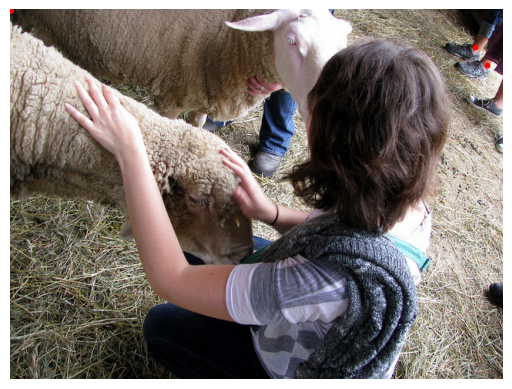

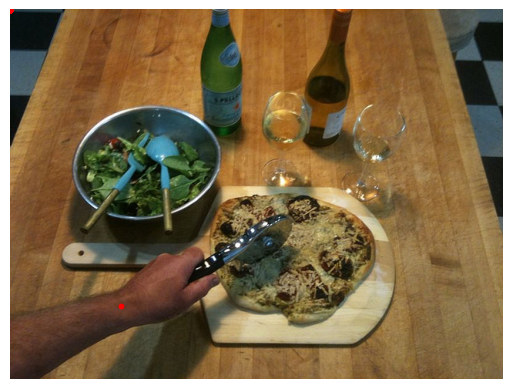

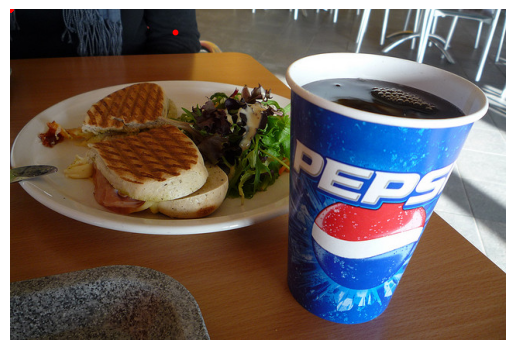

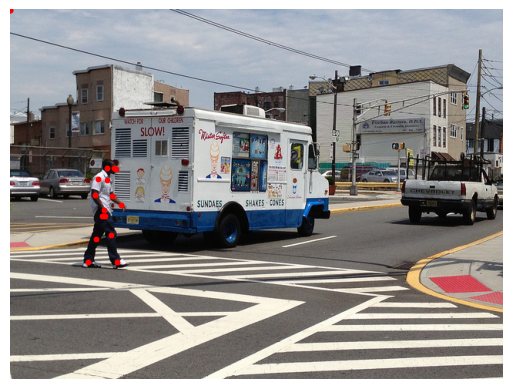

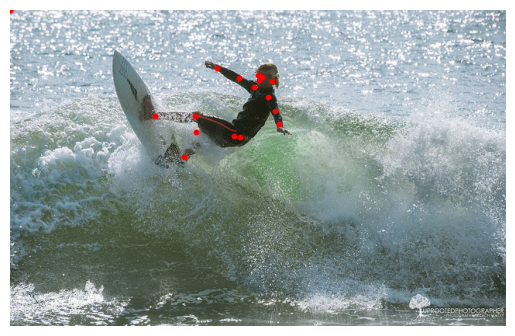

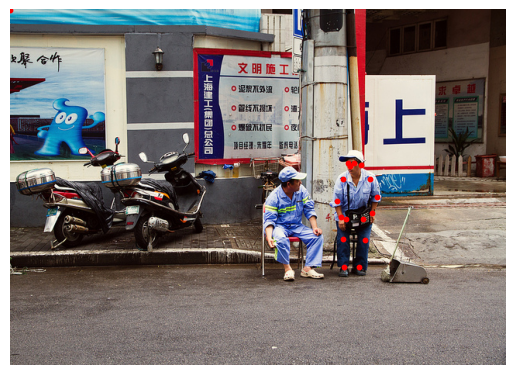

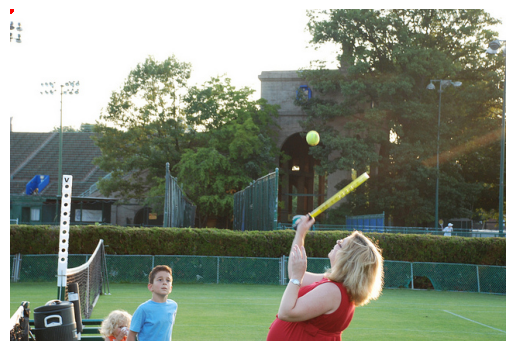

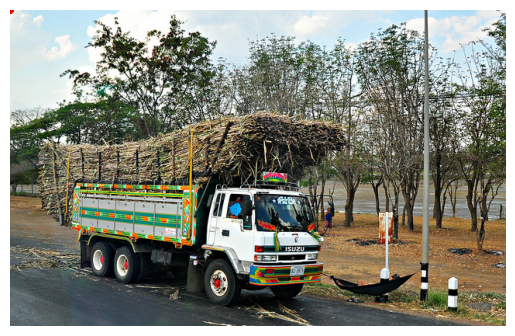

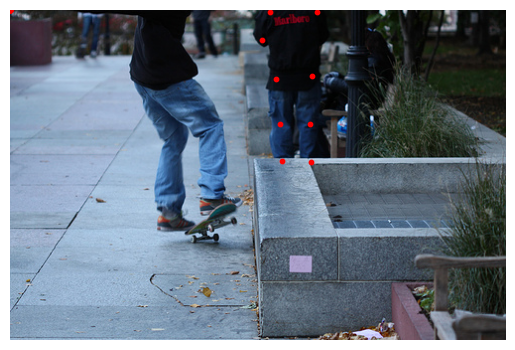

In [79]:
true_keypoints_list = []


for imgId in imgIds:
    
    img_info = coco_kps.loadImgs(imgId)[0]
    img_url = img_info['coco_url']
    
    
    I = io.imread(img_url)
    filename = img_url.split('/')[-1]
    output_path = os.path.join(output_folder, filename)
    
    
    io.imsave(output_path, I)
    
    
    #plt.imshow(I)
    #plt.axis('off')
    #plt.show()
    
    
    annIds = coco_kps.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    keypoints_per_image = []

    
    
    if len(anns) > 1:
        # Selecionar aleatoriamente uma anotação de pessoa
        ann = random.choice(anns)
        keypoints = ann['keypoints']
        if keypoints:
            keypoints = np.array(keypoints).reshape(-1, 3)  
            x = keypoints[:, 0]
            y = keypoints[:, 1]
            plt.scatter(x, y, s=10, c='r')
            keypoints_per_image.append(keypoints.tolist())
    elif len(anns) == 1:
        # Se houver apenas uma anotação de pessoa, usar essa
        ann = anns[0]
        keypoints = ann['keypoints']
        if keypoints:
            keypoints = np.array(keypoints).reshape(-1, 3)  
            x = keypoints[:, 0]
            y = keypoints[:, 1]
            plt.scatter(x, y, s=10, c='r')
            keypoints_per_image.append(keypoints.tolist())
    
    plt.imshow(I)
    plt.axis('off')
    plt.show()

    true_keypoints_list.append(keypoints_per_image)

#print("True keypoints coordenates for the first image:")
#print(true_keypoints_list)

# Model MediaPipe

In [80]:
if not os.path.exists(MEDIAPIPE_IMAGES_DIR):
    os.makedirs(MEDIAPIPE_IMAGES_DIR)

def detect_pose(image_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pose.process(image_rgb)

    # get predicted coordenates:
    predicted_keypoints = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            predicted_keypoints.append((landmark.x, landmark.y))
    # draw landmarks in image pose
    #if results.pose_landmarks:
        #mp_drawing = mp.solutions.drawing_utils
        #annotated_image = image.copy()
        #mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        #if not os.path.exists(MEDIAPIPE_IMAGES_DIR):
            #os.makedirs(MEDIAPIPE_IMAGES_DIR)
        
        # save image with landmarks inside dir'output'
        #file_path = os.path.join(MEDIAPIPE_IMAGES_DIR, f'{os.path.basename(image_path)}')
        #cv2.imwrite(file_path, annotated_image)
        #print("landmarks detected")
    #else:
        #pass
        #print("no landmarks detected")
    pose.close()
    return predicted_keypoints

predicted_keypoints_list_mp = []

files = filter(lambda file:file.endswith('.jpg'), os.listdir(output_folder))
for file in files:
    image_file = os.path.join(output_folder, file)
    predicted_keypoints = detect_pose(image_file)
    predicted_keypoints_list_mp.append(predicted_keypoints)
#print(predicted_keypoints_list_mp)
#detect_pose(image_file)

# Goal structure

In [81]:
#def getLandmarks(x):
    #yHat = {}
    #yHat["MediaPipe"] = getLandmarksMediaPipe(x)
    #yHat["Yolo"] = getLandmarksYolo(x)
    #return yHat

#def evaluateModels(y,yHat):
    #metrics = {}
    #metrics["MediaPipe"] = evaluateMediaPipe(y,yHat)
    #metrics["Yolo"] = evaluateYolo(y,yHat)
    #metrics
#def compareModels(metrics):
    #pass

In [82]:
#x,y = readDataset()
#yHat = getLandmarks(x)
#metrics = evaluateModels(y,yHat)
#compareModels(metrics)

# Model YOLO v8

In [83]:
model = YOLO("yolov8m-pose.pt") 

In [84]:
count = 0
results_list = []


files = filter(lambda file:file.endswith('.jpg'), os.listdir(output_folder))
for file in files:
    image_file = os.path.join(output_folder, file)
    #print("IMAGE FILE", image_file)
    
    results_yolo = model(source = image_file, show = False, conf= 0.5, save= True)
    results_list.append(results_yolo)
    #print("RESULTS LIST", results_list)
    count += 1
    if count >= N:
        break


 # Acess and print predicted keypoints MODEL YOLO
for i,result in enumerate(results_list):
    for r in result:
        #print(len(result))
        image_name = r.path.split('\\')[-1]
        #print(f"image {i+1} ({image_name})")
        xyn = r.keypoints.xyn
        for j, pose in enumerate(xyn):
            #print(f"pose {j+1}")
            for k, landmark in enumerate(pose):
                x, y = landmark
                #print(f"keypoints {k+1}:\t ({x},\t {y})")



image 1/1 C:\Users\bp111\OneDrive\Documentos\Code\YOLO_MediaPipe_COCO_dataset_comparison\raw_images\000000008211.jpg: 480x640 2 persons, 749.7ms
Speed: 3.0ms preprocess, 749.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\pose\predict3

image 1/1 C:\Users\bp111\OneDrive\Documentos\Code\YOLO_MediaPipe_COCO_dataset_comparison\raw_images\000000188439.jpg: 416x640 (no detections), 744.5ms
Speed: 2.0ms preprocess, 744.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\pose\predict3

image 1/1 C:\Users\bp111\OneDrive\Documentos\Code\YOLO_MediaPipe_COCO_dataset_comparison\raw_images\000000311303.jpg: 448x640 1 person, 703.9ms
Speed: 2.0ms preprocess, 703.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\pose\predict3

image 1/1 C:\Users\bp111\OneDrive\Documentos\Code\YOLO_MediaPipe_COCO_dataset_comparison\raw_images\000000327701.jpg: 448x640 2 persons, 686.7ms
Speed: 3.

# CALCULATE METRICS

# Convert the variables to a list of tuples where each element of the extern  list represents an image and each internal element represents the keypoints for that image

In [85]:
# Convert true_keypoints_list
true_keypoints_list_modified = []
for keypoints_per_image in true_keypoints_list:
    keypoints_image = []
    for keypoints in keypoints_per_image:
        keypoints_formatted = [(x, y) for x, y, _ in keypoints]
        keypoints_image.append(keypoints_formatted)
    true_keypoints_list_modified.append(keypoints_image)
#print(true_keypoints_list_modified)

In [86]:
# Convert predicted_keypoints_list_mp
predicted_keypoints_list_mp_modified = []
for keypoints_per_image in predicted_keypoints_list_mp:
    keypoints_image = []
    for x, y in keypoints_per_image:
        keypoints_image.append((x, y))
    predicted_keypoints_list_mp_modified.append([keypoints_image])
#print(predicted_keypoints_list_mp_modified)

In [87]:
# Convert results_list
#converted_results_list = []

#for results in results_list:  
    #keypoints_per_image = []
    #for result in results:  
        #if result.keypoints is not None:
            #for pose in result.keypoints.xyn:
                #pose_keypoints = []
                #for landmark in pose:
                    #x, y = landmark  
                    #pose_keypoints.append((x, y))
                #keypoints_per_image.append(pose_keypoints)
    #converted_results_list.append(keypoints_per_image)

#print(converted_results_list)
    
# extract the coordinates as simple numeric values instead of tensors.

aligned_results_list = []

for image_results in results_list:
    aligned_image_results = []
    for pose in image_results:
        aligned_pose = []
        if pose.keypoints is not None:
            for landmark in pose.keypoints.xyn:
                # check if exist at least 2 coordenates (x, y)
                if len(landmark) >= 2:
                    x_list = [float(x.item()) for x in landmark[0]]
                    y_list = [float(y.item()) for y in landmark[1]]
                    aligned_landmarks = [(x, y) for x, y in zip(x_list, y_list)]
                else:
                    aligned_landmarks = []  
                aligned_pose.append(aligned_landmarks)
        aligned_image_results.append(aligned_pose)
    aligned_results_list.append(aligned_image_results)

#print(aligned_results_list)

# Dictionary

In [88]:
true_keypoints_dict = {}
for i, keypoints_image in enumerate(true_keypoints_list_modified):
    true_keypoints_dict[f"image_{i+1}"] = {}
    for j, keypoints in enumerate(keypoints_image):
        true_keypoints_dict[f"image_{i+1}"][f"keypoints_{j+1}"] = keypoints
#print("true_keypoints_dict", true_keypoints_dict)

# Convert predicted_keypoints_list_mp_modified to an dictionary
predicted_keypoints_dict = {}
true_keypoints_dict_copy = true_keypoints_dict.copy()

# Add predicted values to predicted keypoints
for idx, (image_name, keypoints_dict) in enumerate(true_keypoints_dict_copy.items()):
    predicted_keypoints_dict[image_name] = {}
    
    if idx < len(predicted_keypoints_list_mp_modified):
        predicted_keypoints = predicted_keypoints_list_mp_modified[idx][0] 
        
        # Check if there are predicted keypoints
        if predicted_keypoints:
            for keypoint_key, keypoints in zip(keypoints_dict.keys(), predicted_keypoints):
                predicted_keypoints_dict[image_name][keypoint_key] = keypoints
        else:
            # If no predicted keypoints, keep the structure as it was
            predicted_keypoints_dict[image_name] = keypoints_dict

#print("predicted_keypoints_dict",predicted_keypoints_dict)
    

# Put same structure MediaPipe and COCO

In [89]:
predicted_keypoints_dict_fixed = {}

for image_name, keypoints_data in predicted_keypoints_dict.items():
    keypoints = keypoints_data['keypoints_1']
    if isinstance(keypoints, tuple):
        
        keypoints = [keypoints]
    predicted_keypoints_dict_fixed[image_name] = {'keypoints_1': keypoints}
#print(predicted_keypoints_dict_fixed)

# Compare if the 2 variables have the same structure

true_keypoints_structure = set()
predicted_keypoints_structure = set()


for image_data in true_keypoints_dict.values():
    for keypoints_data in image_data.values():
        true_keypoints_structure.add(type(keypoints_data))


for image_data in predicted_keypoints_dict_fixed.values():
    for keypoints_data in image_data.values():
        predicted_keypoints_structure.add(type(keypoints_data))

# Compare structures
if true_keypoints_structure == predicted_keypoints_structure:
    print(" variables have the same structure.")
else:
    print("variables not equals.")

 variables have the same structure.


# PE metric for MediaPipe

In [90]:
# check the length of the lists of true and predicted keypoints for all images and, if necessary, fill in the shorter lists with coordinates (0, 0).

def pad_keypoints(keypoints, target_length):
    # Fill the keypoint list with (0, 0) to reach the target length
    while len(keypoints) < target_length:
        keypoints.append((0, 0))
    return keypoints

for image_name, true_data in true_keypoints_dict.items():
    predicted_data = predicted_keypoints_dict_fixed.get(image_name)
    
    if predicted_data is None:
        raise ValueError(f"Image {image_name} has no predicted keypoints.")
    
    true_keypoints = true_data['keypoints_1']
    predicted_keypoints = predicted_data['keypoints_1']

####################################
    #print(f"Keypoints for {image_name}:")
    #print(" TRUE Keypoints:")
    #for idx, true_point in enumerate(true_keypoints):
        #print(f"Keypoint {idx+1}: {true_point}")
    
    #print("PREDICTED Keypoints:")
    #for idx, predicted_point in enumerate(predicted_keypoints):
        #print(f"Keypoint {idx+1}: {predicted_point}")
    ########################################
    true_length = len(true_keypoints)
    predicted_length = len(predicted_keypoints)
    
    # If the lengths are different, fill the shortest list with (0, 0)
    if true_length < predicted_length:
        true_keypoints = pad_keypoints(true_keypoints, predicted_length)
    elif predicted_length < true_length:
        predicted_keypoints = pad_keypoints(predicted_keypoints, true_length)
    
    # two lists have the same length
    #print(f"Length of true keypoints for {image_name}: {len(true_keypoints)}")
    #print(f"Length of keypoints predicted for {image_name}: {len(predicted_keypoints)}")


def calculate_pe(true_keypoints, predicted_keypoints):
    total_points = 0
    total_error_percentage = 0.0

    for true_image_name, true_image_data in true_keypoints.items():
        predicted_image_data = predicted_keypoints.get(true_image_name)

        if predicted_image_data is None:
            raise ValueError(f"Image {true_image_name} has no predicted keypoints.")

        true_points = true_image_data['keypoints_1']
        predicted_points = predicted_image_data['keypoints_1']

        # Checks if both lists have the same length
        if len(true_points) != len(predicted_points):
            raise ValueError(f"The lists of true and predicted points for the image {true_image_name} must be the same length.")

        # Calculate the error for each point and add it
        for true_point, predicted_point in zip(true_points, predicted_points):
            true_x, true_y = true_point
            predicted_x, predicted_y = predicted_point

            # ignore, if the true point is (0, 0)
            if true_x == 0 and true_y == 0:
                continue

            total_points += 1

            # Checks whether the predicted point was not detected 
            if predicted_x == 0 and predicted_y == 0:
                total_error_percentage += 1  # Adds 100% error 

            else:
                # Calculates the euclidean distance between points 
                error = ((true_x - predicted_x) ** 2 + (true_y - predicted_y) ** 2) ** 0.5

                # Calculates the percentage error
                error_percentage = error / max(true_x, true_y)
                total_error_percentage += error_percentage

    # Calculates the average percentage error
    mean_error_percentage = (total_error_percentage / total_points) * 100

    return mean_error_percentage

# Calculates PE metric
pe = calculate_pe(true_keypoints_dict, predicted_keypoints_dict_fixed)
#print("PE metric:", pe)


# Put the same structure YOLO and COCO

In [95]:
# Adjust the structure of the predicted_keypoints_yolo_dict variable
adjusted_predicted_keypoints_yolo_dict = {}

for image_name, keypoints_data in predicted_keypoints_yolo_dict.items():
    keypoints = keypoints_data['keypoints_1']
    if isinstance(keypoints, tuple):
        keypoints = [keypoints]
    adjusted_predicted_keypoints_yolo_dict[image_name] = {'keypoints_1': keypoints}

# Check if variables have the same structure
true_keypoints_structure = set()
predicted_keypoints_structure = set()

for image_data in true_keypoints_dict.values():
    for keypoints_data in image_data.values():
        true_keypoints_structure.add(type(keypoints_data))

for image_data in adjusted_predicted_keypoints_yolo_dict.values():
    for keypoints_data in image_data.values():
        predicted_keypoints_structure.add(type(keypoints_data))

if true_keypoints_structure == predicted_keypoints_structure:
    print("variables have the same structure.")
else:
    print("variables do not have the same structure.")

# check and adjust the length of keypoint lists
def pad_keypoints(keypoints, target_length):
    while len(keypoints) < target_length:
        keypoints.append((0, 0))
    return keypoints

for image_name, true_data in true_keypoints_dict.items():
    predicted_data = adjusted_predicted_keypoints_yolo_dict.get(image_name)
    
    if predicted_data is None:
        raise ValueError(f"Image {image_name} doesn't have predicted keypoints by YOLO model.")
    
    true_keypoints = true_data['keypoints_1']
    predicted_keypoints = predicted_data['keypoints_1']

    true_length = len(true_keypoints)
    predicted_length = len(predicted_keypoints)
    
    if true_length < predicted_length:
        true_keypoints = pad_keypoints(true_keypoints, predicted_length)
    elif predicted_length < true_length:
        predicted_keypoints = pad_keypoints(predicted_keypoints, true_length)

    # Print true and predicted keypoints for each image
    #print(f"Image Name: {image_name}")
    #print("True Keypoints:")
    #for idx, (x, y) in enumerate(true_keypoints):
        #print(f"Keypoint {idx+1}: ({x}, {y})")
    
    #print("Predicted Keypoints:")
#if predicted_keypoints:  # Check if predicted_keypoints is not empty
    #for idx, (x, y) in enumerate(predicted_keypoints):
        #print(f"Keypoint {idx+1}: ({x}, {y})")
#else:
    #print("No keypoints predicted for this image.")
#print()  # Add a blank line between images


variables have the same structure.


# PE metric for YOLO

In [92]:
def calculate_pe_yolo(true_keypoints, predicted_keypoints):
    total_points = 0
    total_error_percentage = 0.0

    for image_name, true_data in true_keypoints.items():
        predicted_data = predicted_keypoints.get(image_name)
        
        if predicted_data is None:
            raise ValueError(f"image {image_name} do not has keypoints provided.")
        
        true_keypoints_list = true_data['keypoints_1']
        predicted_keypoints_list = predicted_data['keypoints_1']

        true_length = len(true_keypoints_list)
        predicted_length = len(predicted_keypoints_list)

        if true_length != predicted_length:
            raise ValueError(f"The lists of true and predicted keypoints for the image {image_name} are not the same length .")

        for true_keypoint, predicted_keypoints_per_image in zip(true_keypoints_list, predicted_keypoints_list):
            true_x, true_y = true_keypoint
            
            # Check if there are keypoints predicted in this image
            if predicted_keypoints_per_image and isinstance(predicted_keypoints_per_image, list):
                predicted_x, predicted_y = predicted_keypoints_per_image[0]  
            else:
                # If there are no predicted keypoints or it is not a list, assign default coordinates (0, 0)
                predicted_x, predicted_y = 0, 0

            if true_x == 0 and true_y == 0:  # If the true point is (0, 0), ignore
                continue

            total_points += 1

            if predicted_x == 0 and predicted_y == 0:  # If the predicted point was not detected
                total_error_percentage += 1  # add 100% error
            else:
                # Calculates the Euclidean distance between points
                error = ((true_x - predicted_x) ** 2 + (true_y - predicted_y) ** 2) ** 0.5

                # Calculates the percentage error 
                error_percentage = error / max(true_x, true_y)
                total_error_percentage += error_percentage

    # Calculates the average percentage error 
    mean_error_percentage = (total_error_percentage / total_points) * 100

    return mean_error_percentage

# Calculate PE
pe = calculate_pe_yolo(true_keypoints_dict, adjusted_predicted_keypoints_yolo_dict)
print("PE metrics:", pe)


PE metrics: 100.05241950026269
